The Meterstick package provides a concise and flexible syntax to describe and execute
routine data analysis tasks. The easiest way to learn to use Meterstick is by example.

# For External users

You can open this notebook in [Google Colab](https://colab.research.google.com/github/google/meterstick/blob/master/meterstick_demo.ipynb).

## Installation

You can install from pip for the stable version

In [ ]:
!pip install meterstick

or from GitHub for the latest version.

In [ ]:
!git clone https://github.com/google/meterstick.git
import sys, os
sys.path.append(os.getcwd())

# Demo Starts

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy

from meterstick import *

In [ ]:
np.random.seed(42)
platform = ('Desktop', 'Mobile', 'Tablet')
exprs = ('ctrl', 'expr')
country = ('US', 'non-US')
size = 1000
impressions = np.random.randint(10, 20, size)
clicks = impressions * 0.1 * np.random.random(size)
df = pd.DataFrame({'impressions': impressions, 'clicks': clicks})
df['platform'] = np.random.choice(platform, size=size)
df['expr_id'] = np.random.choice(exprs, size=size)
df['country'] = np.random.choice(country, size=size)
df['cookie'] = np.random.choice(range(5), size=size)

df.loc[df.country == 'US', 'clicks'] *= 2
df.loc[(df.country == 'US') & (df.platform == 'Desktop'), 'impressions'] *= 4
df.head()

,impressions,clicks,platform,expr_id,country,cookie
0,16,0.409625,Desktop,ctrl,non-US,2
1,13,0.943924,Desktop,expr,non-US,2
2,17,1.008037,Tablet,ctrl,non-US,3
3,14,0.143098,Tablet,expr,non-US,3
4,16,1.470001,Desktop,ctrl,non-US,2


# Simple Metrics
There are many built-in simple Metrics in Meterstick. They directly operate on a DataFrame.

## Sum

In [ ]:
Sum('clicks').compute_on(df)

,sum(clicks)
0,1099.946824


## Count

In [ ]:
Count('country').compute_on(df)

,count(country)
0,1000


In [ ]:
Count('country', distinct=True).compute_on(df)

,count(distinct country)
0,2


## Dot (inner product)

In [ ]:
Dot('clicks', 'impressions').compute_on(df)

,sum(clicks * impressions)
0,27755.49293


It can also be normalized.

In [ ]:
Dot('clicks', 'clicks', True).compute_on(df)

,mean(clicks * clicks)
0,1.84451


## Max

In [ ]:
Max('clicks').compute_on(df)

,max(clicks)
0,3.782826


## Min

In [ ]:
Min('clicks').compute_on(df)

,min(clicks)
0,0.000855


## Mean

In [ ]:
Mean('clicks').compute_on(df)

,mean(clicks)
0,1.099947


###Weighted Mean

In [ ]:
Mean('clicks', 'impressions').compute_on(df)

,impressions-weighted mean(clicks)
0,1.253466


##Quantile

In [ ]:
Quantile('clicks').compute_on(df) # Default is median.

,"quantile(clicks, 0.5)"
0,0.926113


In [ ]:
Quantile('clicks', 0.2).compute_on(df)

,"quantile(clicks, 0.2)"
0,0.382284


In [ ]:
Quantile('clicks', (0.2, 0.5)).compute_on(df) # Quantile can take multiple quantiles.

,"quantile(clicks, 0.2)","quantile(clicks, 0.5)"
0,0.382284,0.926113


### Interpolation
You can specify how you want to interpolate the quantile. It could be any of (‘linear’, ‘lower’, ‘higher’, ‘midpoint’, ‘nearest’).

In [ ]:
Quantile('clicks', 0.5, interpolation='higher').compute_on(df)

,"quantile(clicks, 0.5)"
0,0.927078


### Weighted Quantile

In [ ]:
Quantile('clicks', weight='impressions').compute_on(df)

,"impressions-weighted quantile(clicks, 0.5)"
0,1.100915


##Variance

In [ ]:
Variance('clicks').compute_on(df)

,var(clicks)
0,0.635262


###Biased Variance
The default Variance is unbiased, namely, the divisor used in calculations is N - 1. You could set unbiased=False to use N as the divisor.

In [ ]:
Variance('clicks', unbiased=False).compute_on(df)

,var(clicks)
0,0.634627


### Weighted Variance

In [ ]:
Variance('clicks', weight='impressions').compute_on(df)

,impressions-weighted var(clicks)
0,0.757683


##Standard Deviation

In [ ]:
StandardDeviation('clicks').compute_on(df)

,sd(clicks)
0,0.797033


### Biased Standard Deviation
Similar to biased Variance, it's possible to compute biased standard deviation.

In [ ]:
StandardDeviation('clicks', False).compute_on(df)

,sd(clicks)
0,0.796635


### Weighted Standard Deviation

In [ ]:
StandardDeviation('clicks', weight='impressions').compute_on(df)

,impressions-weighted sd(clicks)
0,0.87045


##Coefficient of Variation

In [ ]:
CV('clicks').compute_on(df)

,cv(clicks)
0,0.724611


##Correlation

In [ ]:
Correlation('clicks', 'impressions').compute_on(df)

,"corr(clicks, impressions)"
0,0.249193


###Weighted Correlation

In [ ]:
Correlation('clicks', 'impressions', weight='impressions').compute_on(df)

,"impressions-weighted corr(clicks, impressions)"
0,0.289402


##Covariance

In [ ]:
Cov('clicks', 'impressions').compute_on(df)

,"cov(clicks, impressions)"
0,3.402773


###Weighted Covariance

In [ ]:
Cov('clicks', 'impressions', weight='impressions').compute_on(df)

,"impressions-weighted cov(clicks, impressions)"
0,5.895056


# Slicing
You can group your DataFrame and compute the Metrics on slices.

In [ ]:
Sum('clicks').compute_on(df, 'country')

,sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
Mean('clicks').compute_on(df, ['platform', 'country'])

mean(clicks)
platform country              
Desktop  US           1.411345
         non-US       0.688706
Mobile   US           1.458064
         non-US       0.726992
Tablet   US           1.527596
         non-US       0.729505

# MetricList
You can put multiple Metrics into a MetricList and compute them together. It's not only makes your codes terser, it might make the computation much faster. See Caching section for more infomation.

In [ ]:
MetricList((Sum('clicks'), Count('clicks'))).compute_on(df)

,sum(clicks),count(clicks)
0,1099.946824,1000


In [ ]:
# return_dataframe=False returns a list of results without concatenation. It's
# useful when the results have incompatible indexes.
MetricList((Sum('clicks'), Count('clicks'))).compute_on(df, return_dataframe=False)

[   sum(clicks)
 0  1099.946824,    count(clicks)
 0           1000]

#Arithmetic of Metrics
You can do many arithmetic operations on Metrics. It can also be between a Metric and a scalar. You can call set_name() to give your composite Metric a new name. Internally, we operate on the results returned by Metrics with return_dataframe=False to avoid incompatible DataFrame columns names. However, if both Metrics return DataFrames even when return_dataframe is set to False, you might get lots of NAs. The solution is use rename_columns() to unify the column names. See section "Compare the standard errors between Jackknife and Bootstrap" for an example.

### Add

In [ ]:
(Sum('clicks') + 1).compute_on(df)

,sum(clicks) + 1
0,1100.946824


In [ ]:
sum((Sum('clicks'), Sum('impressions'), 1)).compute_on(df)

,0 + sum(clicks) + sum(impressions) + 1
0,23243.946824


In [ ]:
sum((Sum('clicks'), Sum('impressions'), 1)).set_name('meaningless sum').compute_on(df)

,meaningless sum
0,23243.946824


### Divide

In [ ]:
(Sum('clicks') / Sum('impressions')).compute_on(df)

,sum(clicks) / sum(impressions)
0,0.049675


####Ratio
Since division between two Sums is common, we make a Ratio() Metric as a syntax sugar. Its third arg is the name for the Metric and is optional.

In [ ]:
Ratio('clicks', 'impressions', 'ctr').compute_on(df)

,ctr
0,0.049675


We also support many other common arithmetic operations.

In [ ]:
MetricList(
    (Sum('clicks') - 1,
     -Sum('clicks'),
     2 * Sum('clicks'),
     Sum('clicks')**2,
     2**Mean('clicks'),
     (Mean('impressions')**Mean('clicks')).set_name('meaningless power'))
    ).compute_on(df, melted=True)

,Value
Metric,
sum(clicks) - 1,1.098947e+03
-sum(clicks),-1.099947e+03
2 * sum(clicks),2.199894e+03
sum(clicks) ^ 2,1.209883e+06
2 ^ mean(clicks),2.143468e+00
meaningless power,3.017787e+01


# Output Format
There are two options for you to control the format of the return.
1. return_dataframe: Default True, if False, we try to return a scalar or pd.Series. For complex Metrics it might have no effect and a DataFrame is always returned. For example, all Metrics in the Operations section below always return a DataFrame.

  return_dataframe has different effect on MetricList. If False, MetricList will return a list of DataFrames instead of trying to concat them. This is a convenient way to compute incompatible Metrics together to maximize caching (see section Caching also). There is an attribute "children_return_dataframe" in MetricList which will be passed to children Metrics as their return_dataframe so you can get a list of numbers or pd.Series.
2. melted: Dafault False. It decides if the returned DataFrame is in wide/unmelted or long/melted form. It doesn't have effect if the return is not a DataFrame. 
  - Long/melted means the leftmost index is 'Metric' so

    `MetricList((m1, m2)).compute_on(df, melted=True).loc[m1.name] ≡ m1.compute_on(df, melted=True)`

  - Wide/unmelted means the outermost column index is 'Metric' so

    `MetricList((m1, m2)).compute_on(df)[m1.name] ≡ m1.compute_on(df)`

In [ ]:
Sum('clicks').compute_on(df, return_dataframe=False)

1099.9468240093606

In [ ]:
Count('clicks').compute_on(df, ['platform', 'country'], return_dataframe=False)

platform  country
Desktop   US         182
          non-US     164
Mobile    US         154
          non-US     168
Tablet    US         177
          non-US     155
Name: count(clicks), dtype: int64

In [ ]:
Mean('clicks').compute_on(df, melted=True)

,Value
Metric,
mean(clicks),1.099947


In [ ]:
MetricList((Sum('clicks'), Count('clicks'))).compute_on(df, 'country')

,sum(clicks),count(clicks)
country,,
US,751.791138,513
non-US,348.155686,487


In [ ]:
Quantile('clicks', [0.2, 0.7]).compute_on(df, 'country', melted=True)

Value
Metric                country          
quantile(clicks, 0.2) US       0.609408
                      non-US   0.276149
quantile(clicks, 0.7) US       1.939392
                      non-US   0.925534

In [ ]:
# Don't worry. We will talk more about the pipeline operator "|" later.
(MetricList((Sum('clicks'), Count('clicks')))
 | Jackknife('cookie')
 | compute_on(df, 'country'))

Metric  sum(clicks)              count(clicks)             
              Value Jackknife SE         Value Jackknife SE
country                                                    
US       751.791138    17.415592         513.0    11.906301
non-US   348.155686     7.489326         487.0    15.104966

In [ ]:
(MetricList((Sum('clicks'), Count('clicks')))
 | Bootstrap(n_replicates=100)
 | compute_on(df, 'country', melted=True))

Value  Bootstrap SE
Metric        country                          
sum(clicks)   US       751.791138     22.146768
              non-US   348.155686      9.741319
count(clicks) US       513.000000      0.000000
              non-US   487.000000      0.000000

# Operations

An Operation is a special type of Metric that is built on top of another Metric (called a "child").  A Metric is anything that has the compute_on() method, so the child doesn't need to be a simple Metric like Sum. It could be a MetricList, a composite Metric, or even another Operation.

##Distribution
Compute the child Metric on a DataFrame grouped by a column, then normalize the numbers to 1 within group.

In [ ]:
Distribution('country', Sum('clicks')).compute_on(df)

,Distribution of sum(clicks)
country,
US,0.68348
non-US,0.31652


It's equal to

In [ ]:
(Sum('clicks').compute_on(df, 'country') /
 Sum('clicks').compute_on(df, return_dataframe=False))

,sum(clicks)
country,
US,0.68348
non-US,0.31652


Distribution has an alias Normalize.

In [ ]:
Normalize('country', Sum('clicks')).compute_on(df)

,Distribution of sum(clicks)
country,
US,0.68348
non-US,0.31652


##Cumulative Distribution
Similar to Distribution except that it returns the cumulative sum after normalization, but unlike Distribution the order of the cumulating column matters. As the result, we always sort the column and there is an 'order' arg for you to customize the ordering.

In [ ]:
CumulativeDistribution('country', MetricList(
    (Sum('clicks'), Sum('impressions')))).compute_on(df)

,Cumulative Distribution of sum(clicks),Cumulative Distribution of sum(impressions)
country,,
US,0.68348,0.682247
non-US,1.00000,1.000000


In [ ]:
CumulativeDistribution(
    'country', Sum('clicks'), order=('non-US', 'US')).compute_on(df, 'platform')

Cumulative Distribution of sum(clicks)
platform country                                     
Desktop  non-US                              0.305419
         US                                  1.000000
Mobile   non-US                              0.352301
         US                                  1.000000
Tablet   non-US                              0.294878
         US                                  1.000000

In [ ]:
CumulativeDistribution(
    'country', MetricList((Sum('clicks'), Sum('impressions')))
).compute_on(df, melted=True)

Value
Metric                                   country          
Cumulative Distribution of sum(clicks)      US       0.683480
                                         non-US   1.000000
Cumulative Distribution of sum(impressions) US       0.682247
                                         non-US   1.000000

##PercentChange
Computes the percent change to a certain group on the DataFrame returned by the child Metric. The returned value is the # of percent points.

In [ ]:
PercentChange('country', 'US', Mean('clicks')).compute_on(df)

,mean(clicks) Percent Change
country,
non-US,-51.217428


In [ ]:
mean = Mean('clicks').compute_on(df, 'country')
(mean.loc['non-US'] / mean.loc['US'] - 1) * 100

mean(clicks)   -51.217428
dtype: float64

You can include the base group in your result.

In [ ]:
PercentChange(
    'country',
    'US',
    MetricList((Count('clicks'), Count('impressions'))),
    include_base=True).compute_on(df, 'platform')

count(clicks) Percent Change  count(impressions) Percent Change
platform country                                                                 
Desktop  US                           0.000000                           0.000000
         non-US                      -9.890110                          -9.890110
Mobile   US                           0.000000                           0.000000
         non-US                       9.090909                           9.090909
Tablet   US                           0.000000                           0.000000
         non-US                     -12.429379                         -12.429379

You can also specify multiple columns as the condition columns, then your base value should be a tuple.

In [ ]:
PercentChange(
    ['country', 'platform'],
    ('US', 'Desktop'),
    MetricList((Count('clicks'), Count('impressions'))),
    include_base=True).compute_on(df)

count(clicks) Percent Change  count(impressions) Percent Change
country platform                                                                 
US      Desktop                       0.000000                           0.000000
        Mobile                      -15.384615                         -15.384615
        Tablet                       -2.747253                          -2.747253
non-US  Desktop                      -9.890110                          -9.890110
        Mobile                       -7.692308                          -7.692308
        Tablet                      -14.835165                         -14.835165

##Absolute Change
Very similar to PercentChange, but the absolute difference is returned.

In [ ]:
AbsoluteChange('country', 'US', Mean('clicks')).compute_on(df)

,mean(clicks) Absolute Change
country,
non-US,-0.750581


You can also include the base group in your result.

In [ ]:
AbsoluteChange(
    'country', 'US', Count('clicks'), include_base=True).compute_on(
        df, 'platform', melted=True)

Value
Metric                        platform country       
count(clicks) Absolute Change Desktop  US           0
                                       non-US     -18
                              Mobile   US           0
                                       non-US      14
                              Tablet   US           0
                                       non-US     -22

##Cochran-Mantel-Haenszel statistics
Please refer to the Wikepedia [page](https://en.wikipedia.org/wiki/Cochran%E2%80%93Mantel%E2%80%93Haenszel_statistics) for its definition. Besides the condition column and baseline key that PercentChange and AbsoluteChange take, CMH also needs a column to  stratify. The child Metric must be a ratio of two single-column Metrics or CMH doesn't make sense. So instead of passing
    
    AbsoluteChange(MetricList([a, b])) / AbsoluteChange(MetricList([c, d])),
please use
    
    MetricList([AbsoluteChange(a) / AbsoluteChange(c),
              AbsoluteChange(b) / AbsoluteChange(d)]).

Below we compare MH and PercentChange on two experiments. One experiment doubles click through rate (CTR) on every platform while the other only has spurious improvement by shifting the traffic from a platform with a low CTR (desktop) to one with a high CTR (mobile). PercentChange shows improvements on both while MH only shows improvements on the former.

In [ ]:
np.random.seed(42)
n = 100000
ctr_data = pd.DataFrame(
    {'expr': np.random.choice(('ctrl', 'spurious', 'real'), n)})
# ctrl has half desktop half mobile while experiments have 30% desktop and 70% mobile
ctr_data['platform'] = np.where(
    np.random.binomial(1, np.where(ctr_data.expr == 'ctrl', 0.5, 0.7)) == 0,
    'desktop', 'mobile')
# 'real' experiment doubles ctr while 'spurious' does nothing
ctr_data['ctr'] = np.where(ctr_data.platform == 'desktop', 0.02,
                           0.04) * np.where(ctr_data.expr == 'real', 2, 1)
ctr_data['click'] = np.random.binomial(1, ctr_data['ctr'])

ctr = (Sum('click') / Count('click')).set_name('ctr')
pct = PercentChange('expr', 'ctrl', ctr)
mh = MH('expr', 'ctrl', 'platform', ctr)
MetricList((pct, mh)).compute_on(ctr_data)

,ctr Percent Change,ctr MH Ratio
expr,,
real,132.319757,106.098557
spurious,16.514030,2.916239


## CUPED

It computes the absolute change that has been adjusted using the [CUPED](http://bit.ly/expCUPED) approach. It provides an unbiased estimate to the absolute change with lower variance.

Let's see how it works on a fake data with preperiod metrics that are correlated with postperiod metrics and the effect of the experiment is small and noisy.

In [ ]:
np.random.seed(42)
exprs = ('ctrl', 'expr')
n = 1000
df_prepost = pd.DataFrame({'impressions': np.random.randint(10, 30, n)})
df_prepost['expr_id'] = np.random.choice(exprs, size=n)
df_prepost['cookie'] = np.random.choice(range(20), size=n)
df_prepost['grp'] = np.random.choice(range(10), size=n)
# Preperiod correlates with postperiod.
df_prepost['pre_impressions'] = np.random.normal(df_prepost.impressions, 3)
# Add small and noisy improvements.
df_prepost.loc[df_prepost.expr_id == 'expr', 'impressions'] += np.random.randint(-2, 4, size=len(df_prepost.loc[df_prepost.expr_id == 'expr', 'impressions']))
abs = AbsoluteChange('expr_id', 'ctrl', Mean('impressions'))
cuped = CUPED('expr_id', 'ctrl', Mean('impressions'), Mean('pre_impressions'), 'grp')
MetricList((abs, cuped)).compute_on(df_prepost)

,mean(impressions) Absolute Change,mean(impressions) CUPED Change
expr_id,,
expr,0.631108,0.858025


CUPED essentially fits a linear model of `Postperiod metric ~ 1 + preperiod metric` and uses it to control for the variance in the preperiod.

In [ ]:
from sklearn import linear_model

df_agg = MetricList((Mean('impressions'), Mean('pre_impressions'))).compute_on(df_prepost, ['expr_id', 'grp'])
lm = linear_model.LinearRegression()
lm.fit(df_agg[['mean(pre_impressions)']], df_agg['mean(impressions)'])
theta = lm.coef_[0]
df_agg['adjusted'] = df_agg['mean(impressions)'] - theta * df_agg['mean(pre_impressions)']
adjusted = df_agg.groupby('expr_id').adjusted.mean()
adjusted['expr'] - adjusted['ctrl']

0.8580250730291548

We can see that CUPED's result is similar to the absolute change but has smaller standard error.

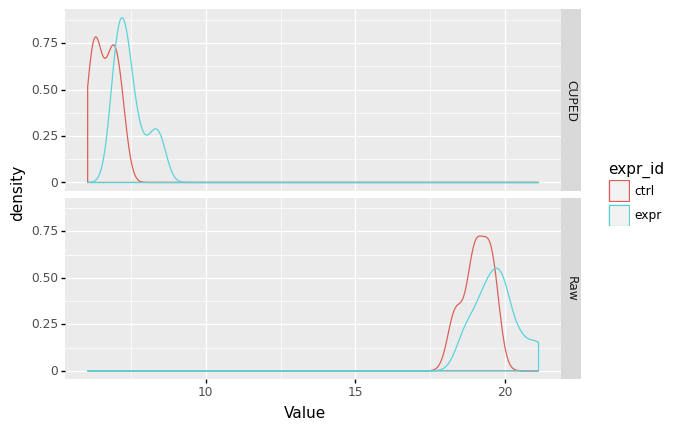

<ggplot: (8780602219783)>

In [ ]:
from plotnine import ggplot, aes, geom_density, facet_grid

data_to_plot = pd.concat([df_agg['mean(impressions)'], df_agg.adjusted], keys=['Raw', 'CUPED'], names=['Adjusted'])
data_to_plot = pd.DataFrame(data_to_plot, columns=['Value']).reset_index()
(
    ggplot(data_to_plot)
    + aes(x="Value", color='expr_id')
    + geom_density()
    + facet_grid('Adjusted ~ .')
)

In [ ]:
# Jackknife is explained in the 'Standard Errors' section.
Jackknife('cookie', MetricList((abs, cuped))).compute_on(df_prepost)

Metric  mean(impressions) Absolute Change  ... mean(impressions) CUPED Change
                                    Value  ...                   Jackknife SE
expr_id                                    ...                               
expr                             0.631108  ...                       0.289659

[1 rows x 4 columns]

In [ ]:
# It's possible to control for multiple metrics.
CUPED('expr_id', 'ctrl', Mean('impressions'),
      [Mean('pre_impressions'), Mean('pre_impressions')**2],
      'cookie').compute_on(df_prepost)

,mean(impressions) CUPED Change
expr_id,
expr,0.877054


## PrePostChange

It computes the percent change that has been adjusted using the [PrePost](https://arxiv.org/pdf/1711.00562.pdf) approach. It's similar to CUPED but control for treatment groups additionally. Essentially, it fits

`Postperiod metric ~ 1 + is_treated * preperiod metric`, or more verbosely,

`Postperiod metric = β1 + β2 * is_treated  + β3 * preperiod metric + β4 * is_treated * preperiod metric`.

Note that the estimate of β2 will be the estimate of treatment effect and the control arm metric can be estimated using β1 if we centered preperiod metric. As the result, β2 / β1 will be the estimate of the percent change that PrePostChange returns.

In [ ]:
pct = PercentChange('expr_id', 'ctrl', Mean('impressions'))
prepost = PrePostChange('expr_id', 'ctrl', Mean('impressions'), Mean('pre_impressions'), 'grp')
MetricList((pct, prepost)).compute_on(df_prepost)

,mean(impressions) Percent Change,mean(impressions) PrePost Percent Change
expr_id,,
expr,3.303519,5.16753


In [ ]:
df_agg = MetricList((Mean('impressions'), Mean('pre_impressions'))).compute_on(
    df_prepost, ['expr_id', 'grp']).reset_index()
df_agg['mean(pre_impressions)'] -= df_agg['mean(pre_impressions)'].mean()
df_agg['is_treated'] = df_agg.expr_id == 'expr'
df_agg['interaction'] = df_agg.is_treated * df_agg['mean(pre_impressions)']
lm = linear_model.LinearRegression()
lm.fit(df_agg[['is_treated', 'mean(pre_impressions)', 'interaction']],
       df_agg['mean(impressions)'])
beta1 = lm.intercept_
beta2 = lm.coef_[0]
beta2 / beta1 * 100

5.167529774048356

In [ ]:
# Jackknife is explained in the 'Standard Errors' section.
Jackknife('cookie', MetricList((pct, prepost))).compute_on(df_prepost)

Metric  mean(impressions) Percent Change  ... mean(impressions) PrePost Percent Change
                                   Value  ...                             Jackknife SE
expr_id                                   ...                                         
expr                            3.303519  ...                                 1.588386

[1 rows x 4 columns]

## Standard Errors

###Jackknife
Unlike all Metrics we have seen so far, Jackknife returns a multiple-column DataFrame because by default we return point estimate and standard error.

In [ ]:
Jackknife('cookie', MetricList((Sum('clicks'), Sum('impressions')))).compute_on(df)

Metric  sum(clicks)              sum(impressions)             
              Value Jackknife SE            Value Jackknife SE
0       1099.946824    21.984759          22143.0   766.551342

In [ ]:
metrics = MetricList((Sum('clicks'), Sum('impressions')))
Jackknife('cookie', metrics).compute_on(df, 'country', True)

Value  Jackknife SE
Metric           country                            
sum(clicks)      US         751.791138     17.415592
                 non-US     348.155686      7.489326
sum(impressions) US       15107.000000    639.214017
                 non-US    7036.000000    243.124330

You can also specify a confidence level, the we'll return the confidence interval. The returned DataFrame also comes with a display() method for visualization which will highlight significant changes. To customize the display(), please take a look at confidence_interval_display_demo.ipynb.

In [ ]:
Jackknife('cookie', metrics, 0.9).compute_on(df)

Metric  sum(clicks)                     ...   sum(impressions)                   
              Value Jackknife CI-lower  ... Jackknife CI-lower Jackknife CI-upper
0       1099.946824        1053.078686  ...       20508.829989       23777.170011

[1 rows x 6 columns]

In [ ]:
res = (
    MetricList((Ratio('clicks', 'impressions', 'ctr'), Sum('clicks')))
    | PercentChange('country', 'US')
    | Jackknife('cookie', confidence=0.9)
    | compute_on(df, 'platform'))
res.display()

Dimensions,ctr,sum(clicks)
USDesktop,0.0250,256.8647
non-USDesktop,"0.047790.44%[65.99, 114.89] %","112.9478-56.03%[-66.78, -45.28] %"
USMobile,0.0994,224.5419
non-USMobile,"0.0513-48.37%[-54.73, -42.02] %","122.1347-45.61%[-57.18, -34.04] %"
USTablet,0.1045,270.3845
non-USTablet,"0.0495-52.67%[-55.69, -49.66] %","113.0732-58.18%[-66.53, -49.83] %"


When all the leaf Metrics are `Sum` and/or `Count`, or can be expressed by them, it's possible to take shortcuts when computing leave-one-out (LOO) estimates in  `Jackknife`. For example,  the LOO estimates for `Jackknife('grp', Sum(x)).compute_on(df)` can be computed faster using the result of `Sum(x).compute_on(df) - Sum(x).compute_on(df, 'grp')`.

By default we uses this trick whenever possible. Besides `Jackknife(Sum(x))`, the trick are applicable to many other `Metric`s, for example, 
- `Metric`s that have a chain of `Operation`s, like `Jackknife(PercentChange(Sum(x)))`.
- `Jackknife(Dot(x, y))` where `Dot(x, y)` will automatically be replaced by `Sum(x * y)` and a temporary column `x * y` will be creaetd on the fly.
- `Jackknife(Variance(x))` where `Variance(x)` will automatically be replaced by `Mean(x`<sup>2</sup>`)` - `Mean(x)`<sup>2</sup>, then `Mean`s are further replaced by `Sum / Count`.

You can check if the trick will be used by checking `Jackknife().can_precompute()`. If you data sum to really large numbers, you might get into `OverflowError`. In that case you can try disabling the trick by using `Jackknife(..., enable_optimization=False)`.

###Bootstrap
The output is similar to Jackknife. The different args are
  - unit: If None, we bootstrap on rows. Otherwise we do a [block bootstrap](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)#Block_bootstrap). The unique values in unit column will be used as the resampling buckets.
  - n_replicates: The number of resamples. Default to 10000, which is recommended in Tim Hesterberg's [What Teachers Should Know About the Bootstrap](https://amstat.tandfonline.com/doi/full/10.1080/00031305.2015.1089789). Here we use a smaller number for faster demonstration.

In [ ]:
np.random.seed(42)
Bootstrap(None, Sum('clicks'), 100).compute_on(df)

Metric  sum(clicks)             
              Value Bootstrap SE
0       1099.946824    25.179947

In [ ]:
np.random.seed(42)
Bootstrap('cookie', Sum('clicks'), 100).compute_on(df, 'country')

Metric  sum(clicks)             
              Value Bootstrap SE
country                         
US       751.791138    19.492354
non-US   348.155686     8.691448

In [ ]:
np.random.seed(42)
Bootstrap('cookie', Sum('clicks'), 100, 0.95).compute_on(df, 'country')

Metric  sum(clicks)                                      
              Value Bootstrap CI-lower Bootstrap CI-upper
country                                                  
US       751.791138         713.114079         790.468196
non-US   348.155686         330.909968         365.401405

In [ ]:
np.random.seed(42)
res = (
    MetricList((Ratio('clicks', 'impressions', 'ctr'), Sum('impressions')))
    | AbsoluteChange('country', 'US')
    | Bootstrap(None, n_replicates=100, confidence=0.9)
    | compute_on(df, 'platform'))
res.display()

# Models

Meterstick also has built-in support for model fitting. The module is not imported by default, so you need to manually import it.

In [ ]:
from meterstick.models import *

## Linear Regression

In [ ]:
m = LinearRegression(Mean('clicks'), Mean('impressions'), 'platform')
m.compute_on(df)

,OLS(mean(clicks) ~ mean(impressions)) Coefficient: intercept,OLS(mean(clicks) ~ mean(impressions)) Coefficient: mean(impressions)
0,1.146237,-0.002108


What `Model(y, x, groupby).compute_on(data)` does is
1. Computes `MetricList((y, x)).compute_on(data, groupby)`.
2. Fits the underlying sklearn model on the result from #1.

In [ ]:
from sklearn import linear_model

x = Mean('impressions').compute_on(df, 'platform')
y = Mean('clicks').compute_on(df, 'platform')
m = linear_model.LinearRegression().fit(x, y)
print(m.coef_, m.intercept_)

[[-0.00210791]] [1.14623671]


## Ridge Regression

In [ ]:
# x can also be a list of Metrics or a MetricList.
m = Ridge(
    Mean('clicks'),
    [Mean('impressions'), Variance('clicks')],
    'platform',
    alpha=2)
m.compute_on(df, melted=True)

,Value
Metric,
Ridge(mean(clicks) ~ mean(impressions) + var(clicks)) Coefficient: intercept,1.146459
Ridge(mean(clicks) ~ mean(impressions) + var(clicks)) Coefficient: mean(impressions),-0.002096
Ridge(mean(clicks) ~ mean(impressions) + var(clicks)) Coefficient: var(clicks),-0.000753


## Lasso Regression

In [ ]:
m = Lasso(
    Mean('clicks'),
    Mean('impressions'),
    'platform',
    fit_intercept=False,
    alpha=5)
m.compute_on(df, 'country')

,Lasso(mean(clicks) ~ mean(impressions)) Coefficient: mean(impressions)
country,
US,0.030022
non-US,0.025534


## Logistic Regression

In [ ]:
m = LogisticRegression(Count('clicks'), Mean('impressions'), 'country')
m.compute_on(df, melted=True)

,Value
Metric,
LogisticRegression(count(clicks) ~ mean(impressions)) Coefficient: intercept,-10.110804
LogisticRegression(count(clicks) ~ mean(impressions)) Coefficient: mean(impressions),0.460627


If y is not binary, by default a multinomal model is fitted. The behavior can be controlled via the '[multinomial](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)' arg.

In [ ]:
m = LogisticRegression(Count('clicks'), Mean('impressions'), 'platform', name='LR')
m.compute_on(df, melted=True)

,Value
Metric,
LR Coefficient: intercept for class 322,4.086943
LR Coefficient: mean(impressions) for class 322,-0.181760
LR Coefficient: intercept for class 332,3.030410
LR Coefficient: mean(impressions) for class 332,-0.109727
LR Coefficient: intercept for class 346,-7.117353
LR Coefficient: mean(impressions) for class 346,0.291487


Classes are the unique values of y.

In [ ]:
Count('clicks').compute_on(df, 'platform')

,count(clicks)
platform,
Desktop,346
Mobile,322
Tablet,332


Wrapping sklearn models into Meterstick provides the ability to combine Models with other built-in Metrics and Operations. For example, you can Jackknife the Model to get the uncertainty of coefficients.

In [ ]:
(LinearRegression(
    Mean('clicks'),
    [Mean('impressions'), Variance('impressions')],
    'country',
    name='lm')
 | AbsoluteChange('platform', 'Desktop')
 | Jackknife('cookie', confidence=0.9)
 | compute_on(df)).display()

#Pipeline
You have already seen this. Instead of

    Jackknife(PercentChange(MetricList(...))).compute_on(df)
you can write

    MetricList(...) | PercentChange() | Jackknife() | compute_on(df)

which is more intuitive. We overwrite the "|" operator on Metric and the \_\_call\_\_() of Operation so a Metric can be pipelined to an Operation. As Operation is a special kind of Metric, so it can bu further pipelined to another Operation. At last, compute_on() takes a Metric from the pipeline and is equavalent to calling metric.compute_on().

#Filter

There is a "where" arg for Metric. It'll be passed to df.query() at the beginning of compute_on(df). By default the filter is not reflected in the name of Metric so same Metrics with different filters would have same column names in the returned DataFrames. It makes combining them easy.

In [ ]:
clicks_us = Sum('clicks', where='country == "US"')
clicks_not_us = Sum('clicks', where='country != "US"')
(clicks_not_us - clicks_us).compute_on(df)

,sum(clicks) - sum(clicks)
0,-403.635452


It's equivalent to

In [ ]:
Sum('clicks') | AbsoluteChange('country', 'US') | compute_on(df)

,sum(clicks) Absolute Change
country,
non-US,-403.635452


#SQL

You can easily get SQL query for all built-in Metrics and Operations, except for weighted Quantile/CV/Correlation/Cov, by calling

> to_sql(sql_table, split_by).

You can also directly execute the query by calling
> compute_on_sql(sql_table, split_by, execute, melted),

where `execute` is a function that can execute SQL queries. The return is very similar to compute_on().

The dialect it uses is the [standard SQL](https://cloud.google.com/bigquery/docs/reference/standard-sql) in Google Cloud's BigQuery.

Additionally, `compute_on_sql` also takes a `mode` arg. It can be `None` (default and recommended), `'mixed'` or `'magic'`. The mode controls how we split the computation between SQL and Python. For example, for a Metric with descendants, we can compute everything in SQL (if applicable), or the children in SQL and the parent in Python, or grandchildren in SQL and the rest in Python. The default `None` mode maximizes the SQL usage, namely, everything can be computed in SQL is computed in SQL. The `mixed` mode does the opposite. It minimizes the SQL usage, namely, only leaf Metrics are computed in SQL. The advantage of the `sql` mode is that SQL is usually faster and can handle larger data than Python. On the other hand, as all the `Metric`s computed in Python will be cached, the `mixed` mode will cache all levels of `Metric`s in the `Metric` tree. As a result, if you have a complex `Metric` that has many duplicated leaf `Metric`s, the `mixed` mode could be faster.

There is another `magic` mode that only applies to `Model`s. The mode computes sufficient statistics in SQL then use them to solve the coefficients in Python. It's faster then the regular modes when fitting `Model`s on large data.

For `Jackknife` and `Bootstrap`, `compute_on_sql` also takes a `batch_size` arg which only has effect in the `mixed` mode and controls how many resamples to obtain in each iteration.

In [ ]:
MetricList((Sum('X', where='Y > 0'), Sum('X'))).to_sql('T', 'grp')

SELECT
  grp,
  SUM(IF(Y > 0, X, NULL)) AS sum_X,
  SUM(X) AS sum_X_1
FROM T
GROUP BY grp

In [ ]:
m = MetricList((Sum('clicks'), Mean('impressions')))
m = AbsoluteChange('country', 'US', m)
m.compute_on(df, 'platform')

,,sum(clicks) Absolute Change,mean(impressions) Absolute Change
platform,country,,
Desktop,non-US,-143.916922,-41.928504
Mobile,non-US,-102.407265,-0.502706
Tablet,non-US,-157.311265,0.132568


In [ ]:
from sqlalchemy import create_engine

engine = create_engine('sqlite://', echo=False)
df.to_sql('T', con=engine)
# Meterstick uses a different SQL dialect from SQLAlchemy, so this doesn't
# always work.
m.compute_on_sql('T', 'platform', execute=lambda sql: pd.read_sql(sql, engine))

,,sum(clicks) Absolute Change,mean(impressions) Absolute Change
platform,country,,
Desktop,non-US,-143.916922,-41.928504
Mobile,non-US,-102.407265,-0.502706
Tablet,non-US,-157.311265,0.132568


#Custom Metric
We provide many Metrics out of box but we understand there are cases you need more, so we make it easy for you to write you own Metrics.
First you need to understand the dataflow of a DataFrame when it's passed to compute_on(). The dataflow looks like this.

		    <-------------------------------------------compute_on(handles caching)---------------------------------------------->
		    <-------------------------------------compute_through----------------------------------->                            |
		    |                                              <------compute_slices------>             |                            |
		    |                                              |-> slice1 -> compute |    |             |                            |
		df -> df.query(where) -> precompute -> split_data -|-> slice2 -> compute | -> pd.concat  -> postcompute -> manipulate -> final_compute
		                                                   |-> ...			   |

In summary, compute() operates on a slice of data and hence only takes one arg, df. While precompute(), postcompute(), compute_slices(), compute_through() and final_compute() operate on the whole DataFrame so they take the df that has been processed by the dataflow till them and the split_by passed to compute_on(). final_compute() also has access to the original df passed to compute_on() for you to make additional manipulation. manipulate() does common data manipulation like melting and cleaning. Besides wrapping all the computations above, compute_on() also caches the result from compute_through(). Please refer to the section of Caching for more details.

Depending on your case, you can overwrite all the methods, but we suggest you NOT to overwrite compute_on() because it might mess up the caching mechanism, nor manipulate(), because it might not work well with other Metrics' data manipulation. Here are some rules to help you decide.
1. If your Metric has no vectorization over slices, overwrite compute() which only takes one arg, df. To overwrite, you can either create a new class inheriting from Metric or just pass a lambda function into Metric.
2. If you have vectorization logic over slices, overwrite compute_slices().
3. As compute() operates on a slice of data, it doesn't have access to the columns to split_by and the index value of the slice. If you need them, overwrite compute_with_split_by(self, df, split_by, slice_name), which is just a wrapper of compute(), but has access to split_by and the value of current slice, slice_name.
4. The data passed into manipulate() should be a number, a pd.Series, or a wide/unmelted pd.DataFrame.
5. split_data() returns (sub_dataframe, corresponding slice value). You might want to overwrite it for non-vectorized Operations. See section Linear Regression for examples.

Also there are some requirements.
1. Your Metric shouldn't change the input DataFrame inplace or it might not work with other Metrics.
2. Your Metric shouldn't rely on the index of the input DataFrame if you want it to work with Jackknife. The reason is Jackknife might reset the index.


## No Vectorization

In [ ]:
class CustomSum(Metric):
  def __init__(self, var):
    name = 'custom sum(%s)' % var
    super(CustomSum, self).__init__(name)
    self.var = var

  def compute(self, df):
    return df[self.var].sum()

CustomSum('clicks').compute_on(df, 'country')

,custom sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
Sum('clicks').compute_on(df, 'country')

,sum(clicks)
country,
US,751.791138
non-US,348.155686


CustomSum doesn't have vectorization. It loops through the DataFrame and sum on every slice. As the result, it's slower than vectorized summation.

In [ ]:
%%timeit
CustomSum('clicks').compute_on(df, 'country')

100 loops, best of 3: 5.18 ms per loop


In [ ]:
%%timeit
Sum('clicks').compute_on(df, 'country')

100 loops, best of 3: 2.13 ms per loop


In [ ]:
%%timeit
df.groupby('country')['clicks'].sum()

100 loops, best of 3: 1.45 ms per loop


## With Vectorization

We can do better. Let's implement a Sum with vectorization.

In [ ]:
class VectorizedSum(Metric):
  def __init__(self, var):
    name = 'vectorized sum(%s)' % var
    super(VectorizedSum, self).__init__(name = name)
    self.var = var

  def compute_slices(self, df, split_by):
    if split_by:
      return df.groupby(split_by)[self.var].sum()
    return df[self.var].sum()

VectorizedSum('clicks').compute_on(df, 'country')

,vectorized sum(clicks)
country,
US,751.791138
non-US,348.155686


In [ ]:
%%timeit
VectorizedSum('clicks').compute_on(df, 'country')

1000 loops, best of 3: 1.77 ms per loop


## Precompute, postcompute and final_compute

They are useful when you need to preprocess and postprocess the data.

In [ ]:
class USOnlySum(Sum):

  def precompute(self, df, split_by):
    return df[df.country == 'US']

  def postcompute(self, data, split_by):
    print('Inside postcompute():')
    print('Input data: ', data)
    print('Input split_by: ', split_by)
    print('\n')
    return data

  def final_compute(self, res, melted, return_dataframe, split_by, df):
    # res is the result processed by the dataflow till now. df is the original
    # DataFrme passed to compute_on().
    print('Inside final_compute():')
    for country in df.country.unique():
      if country not in res.index:
        print('Country "%s" is missing!' % country)
    return res


USOnlySum('clicks').compute_on(df, 'country')

Inside postcompute():
Input data:  country
US    751.791138
Name: clicks, dtype: float64
Input split_by:  ['country']


Inside final_compute():
Country "non-US" is missing!


,sum(clicks)
country,
US,751.791138


##Custom Operation
Writing a custom `Operation` is more complex. Typically an `Operation` needs to compute some util `Metric`s. A common one is its child `Metric`. The tricky part is how to make sure the additional computations interact correctly with the cache. First take a look at the Caching section below to understand how caching works in `Meterstick`. Then here is a decision tree to help you.


                +-----------------------------------+                            
                | Want the util Metric to share     |
                | caching with other Metrics?       |-----------→                
                +-----------------------------------+           ↓                
                                  ↓                             |                
                                  |                             |                
                                  Y                             N                
                                  ↓                             |                
                 +-------------------------------+              |                
                 |Using the data from the input  |              |                
                 |of the method being overridden?|              |                
                 +-------------------------------+              ↓                
                                  ↓                   +----------------------+
                                  |                   |Call compute_on() or  | 
                                  |------------N----->|compute_on_sql() on   |
                                  |                   |the util Metric. Set  |
                                  Y                   |precomputable_in_jk_bs|
                                  |                   |to False.             |
                                  |                   +----------------------+
                                  ↓                                              
                 +-------------------------------+                               
                 |Is the Metric the child Metric?|                               
                 +-------------------------------+                               
                                  ↓                                              
                        Y---------|--------N                                     
                        ↓                  ↓                                     
             +----------------------+  +-------------------------------+         
             |Use compute_child()   |  |Use compute_util_metric_on()   |         
             |or compute_child_sql()|  |or compute_util_metric_on_sql()|         
             +----------------------+  +-------------------------------+

1. All `Metric` instances in one computation point to the same cache, so the first
question is do you need your util `Metric` to connect to the cache to share the caching. If no, you can just call the `compute_on` or `compute_on_sql` on the util `Metric`. You also need to set the `precomputable_in_jk` attribute of the `Operation` to `False`. The reason is explained below.
1. We don't check if the input data is consistent when using caching so users need to make sure the util `Metric` is computed on the same data as other `Metric`s are. If the util `Metric` is computed on the data passed to the method your are overriding, it's safe to use the recommended methods below that will save the result to cache.
1. A very common scenerio is that an `Operation` needs to compute the child `Metric` first. Use `compute_child` or `compute_child_sql` to do so. Oftentimes the child `Metric` needs to be computed with an extended `split_by`, for example, `PercentChange('grp', 'base', Sum(x)).compute_on(data, 'foo')` will need to compute `Sum(x).compute_on(data, ['foo', 'grp'])` first. The recommended way is that you register the extra dimensions, `grp` in the example, in `__init__()`. Then the default `compute_child` and `compute_child_sql` will return the result of the child `Metric` you want. You only need to implement the `compute_on_children` then.
1. The extra dimensions are stored in `self.extra_split_by`. There is another attribute `extra_index` which stores the indexes the `Operation` adds. When unspecified, it will be set to the value of `self.extra_split_by`. For complex `Operations` the two can differ. For example, in the computation of `MH(condition_column, baseline_key, stratified_by, child)`, we need to compute `child.compute_on(df, split_by + [condition_column, stratified_by])` so the `extra_split_by` is `[condition_column, stratified_by]`. However, `stratified_by` won't show up in the final result so you need to explicitly set the `extra_index` to `condition_column`.
1. When you need to manually construct the extended `split_by`, make the extra dimensions come after the original `split_by`. That's how we do it for all built-in `Operation`s so the caching could be maximized.
1. Try to vectorize the `Operation` as much as possible. If it's hard to vectorize, often you can at least compute the child `Metric` in a vectorized way by calling `compute_child`. Then implement `compute(self, df_slice)` which handles a slice of the data returned by the child `Metric`. See `CumulativeDistribution` below for an example.
1. When you need to compute a util `Metric` other than the child `Metric`, use `compute_util_metric_on` or `compute_util_metric_on_sql`. `compute_child` and `compute_child_sql` are just wrappers of them for the child `Metric`.
1. If the `Operation` has additional attributes that affect the computation logic, register them to `additional_fingerprint_attrs`. The `fingerprint` contains all the attributes that decide the result of a Metric except the name. In other words, if two instances have the same fingerprint, they should always compute to the same result, with the only exception that the column names can be different.
1. As explained in the `Jackknife` and `Bootstrap` section, we take shortcuts when leaf `Metric`s are `Sum` and/or `Count` or can be expressed by them. It speeds up the computation. If you want your `Operation` to work with `Jackknife`/`Bootstrap` in a fast way, try to delegate the computations to `Sum`, `Count`, or `Metric`s that can be expressed by them, which includes `Mean`, `Dot`, `Variance`, `StandardDeviation`, `CV`, `Correlation` and `Cov`. See section Linear Regression for a performance comparison.
1. When taking the shortcut, `Jackknife`/`Bootstrap` will just emit `None` as the resampled data. The reason is that the LOO estimates have been precomputed and saved in cache so there is no need to emit real data. This will be a problem for you if you ever call `compute_on` or `compute_on_sql` in your computation logic. You can either
      * ensure that your computation still works when the input data is `None`.
      * set attribute `precomputable_in_jk_bs` to `False`, which will stop `Jackknife`/`Bootstrap` from taking the shortcuts, and make the computation slower.
1. An `Operation` might not be precomputable even all the leaf `Metric`s are `Sum` and/or `Count`. It's not easy to decide. The easiest way to check is just set the `precomputable_in_jk_bs` to `True` and try `Metric`s like 

  - `Jackknife(..., Operation(Dot('x', 'y', where='x>2')))` and
  - `Jackknife(..., Operation(Dot('x', 'y', where='x>2')), enable_optimization=False)`. 

  If the first one computes and gives the same result to the second one, the `Operation` is precomputable. See the doc of `Operation` for the attribute for
more details if you're curious.

That's a lot to digest. Let's see two examples. `Distribution` has a vectorized computation logic while `CumulativeDistribution` doesn't.

In [ ]:
class Distribution(Operation):
  """Computes the normalized values of a Metric over column(s)."""

  def __init__(self,
               over: Union[Text, List[Text]],
               child: Optional[Metric] = None,
               **kwargs):
    self.over = over
    # The 3rd argument is the extra column that will be added to `split_by`.
    # It'll be converted to a list then assigned to `self.extra_index`. `over`
    # also affects the computation logic so it should be included in the
    # attributes that determine the fingerprint. However, by default Operation
    # already includes `extra_index` in the attributes for the fingerprint so
    # there is no need to add `over` to `additional_fingerprint_attrs`.
    # Also pass `kwargs` around to capture common args like `name` and `where`.
    super(Distribution, self).__init__(child, 'Distribution of {}', over,
                                       **kwargs)

  def compute_on_children(self, children, split_by):
    # `children` is the default return of self.compute_child(). It equals
    # child.compute_on(df, split_by + self.over).
    total = children.groupby(
        level=split_by).sum() if split_by else children.sum()
    return children / total

In [ ]:
class CumulativeDistribution(Operation):
  """Computes the normalized cumulative sum."""

  def __init__(self,
               over: Text,
               child: Optional[Metric] = None,
               order=None,
               ascending: bool = True,
               **kwargs):
    self.order = order
    self.ascending = ascending
    # 'order' and 'ascending' affect the computation but are not part of the
    # extra_index so we need to manually add them to the
    # additional_fingerprint_attrs.
    # Also pass `kwargs` around to capture common args like `name` and `where`.
    super(CumulativeDistribution, self).__init__(
        child,
        'Cumulative Distribution of {}',
        over,
        additional_fingerprint_attrs=['order', 'ascending'],
        **kwargs)

  def compute(self, df):
    # It's hard to vectorize for CumulativeDistribution so we implement
    # `compute` instead of `compute_on_children`. df is a slice of the
    # `children` in `compute_on_children`. We will take care of iterating slices
    # and the concatenation of results.
    if self.order:
      df = pd.concat((
          df.loc[[o]] for o in self.order if o in df.index.get_level_values(0)))
    else:
      df.sort_values(self.extra_index, ascending=self.ascending, inplace=True)
    dist = df.cumsum()
    dist /= df.sum()
    return dist

## SQL Generation

If you want the custom Metric to generate SQL query, you need to implement to_sql() or get_sql_and_with_clause(). The latter is more common and recommended. Please refer to built-in Metrics to see how it should be implemented. Here we show two examples, one for Metric and the other for Operation.

In [ ]:
class SumWithSQL(SimpleMetric):

  def __init__(self,
               var: Text,
               name: Optional[Text] = None,
               where: Optional[Text] = None,
               **kwargs):
    super(SumWithSQL, self).__init__(var, name, 'sum({})', where, **kwargs)
    self._sum = Sum(var, name, where, **kwargs)

  def compute_slices(self, df, split_by):
    return self._sum.compute_slices(df, split_by)

  # All the SQL-related classes, like Datasource, Filters, Columns, and so on,
  # are defined in sql.py.
  def get_sql_and_with_clause(self, table: Datasource, split_by: Columns,
                              global_filter: Filters, indexes: Columns,
                              local_filter: Filters, with_data: Datasources):
    del indexes  # unused
    # Always starts with this line unless you know what you are doing.
    local_filter = Filters([self.where, local_filter]).remove(global_filter)
    columns = Column(self.var, 'SUM({})', self.name, local_filter)
    # Returns a Sql instance and the WITH clause it needs.
    return Sql(columns, table, global_filter, split_by), with_data

In [ ]:
m = Sum('clicks') - SumWithSQL('clicks', 'custom_sum')
m.compute_on_sql('T', 'platform', execute=lambda sql: pd.read_sql(sql, engine))

,sum(clicks) - custom_sum
platform,
Desktop,0.0
Mobile,0.0
Tablet,0.0


For an Operation, you ususally call the child metrics' get_sql_and_with_clause() to get the subquery you need.

In [ ]:
class DistributionWithSQL(Operation):

  def __init__(self,
               over: Union[Text, List[Text]],
               child: Optional[Metric] = None,
               **kwargs):
    super(DistributionWithSQL, self).__init__(child, 'Distribution of {}', over,
                                              **kwargs)

  def compute_slices(self, df, split_by=None):
    lvls = split_by + self.extra_index if split_by else self.extra_index
    res = self.compute_child(df, lvls)
    total = res.groupby(level=split_by).sum() if split_by else res.sum()
    return res / total

  def get_sql_and_with_clause(self,
                              table: Datasource,
                              split_by: Columns,
                              global_filter: Filters,
                              indexes: Columns,
                              local_filter: Filters,
                              with_data: Datasources):
    """Gets the SQL query and WITH clause.

    The query is constructed by
    1. Get the query for the child metric.
    2. Keep all indexing/groupby columns unchanged.
    3. For all value columns, get
      value / SUM(value) OVER (PARTITION BY split_by).

    Args:
      table: The table we want to query from.
      split_by: The columns that we use to split the data.
      global_filter: The Filters that can be applied to the whole Metric tree.
      indexes: The columns that we shouldn't apply any arithmetic operation.
      local_filter: The Filters that have been accumulated so far.
      with_data: A global variable that contains all the WITH clauses we need.

    Returns:
      The SQL instance for metric, without the WITH clause component.
      The global with_data which holds all datasources we need in the WITH
        clause.
    """
    # Always starts with this line unless you know what you are doing.
    local_filter = Filters([self.where, local_filter]).remove(global_filter)
    # The intermediate tables needed by child metrics will be added to with_data
    # in-place.
    child_sql, with_data = self.children[0].get_sql_and_with_clause(
        table, indexes, global_filter, indexes, local_filter, with_data)
    child_table = sql.Datasource(child_sql, 'DistributionRaw')
    # Always use the alias returned by with_data.add(), because if the with_data
    # already holds a different table that also has 'DistributionRaw' as its
    # alias, we'll use a different alias for the child_table, which is returned
    # by with_data.add().
    child_table_alias = with_data.add(child_table)
    groupby = sql.Columns(indexes.aliases, distinct=True)
    columns = sql.Columns()
    for c in child_sql.columns:
      if c.alias in groupby:
        continue
      col = sql.Column(c.alias) / sql.Column(
          c.alias, 'SUM({})', partition=split_by.aliases)
      col.set_alias('Distribution of %s' % c.alias_raw)
      columns.add(col)
    return sql.Sql(groupby.add(columns), child_table_alias), with_data


m = DistributionWithSQL('country', Sum('clicks'))
m.to_sql('T')

WITH
DistributionRaw AS (SELECT
  country,
  SUM(clicks) AS sum_clicks
FROM T
GROUP BY country)
SELECT
  country,
  SAFE_DIVIDE(sum_clicks, SUM(sum_clicks) OVER ()) AS Distribution_of_sum_clicks
FROM DistributionRaw
GROUP BY country, Distribution_of_sum_clicks

# Caching

tl;dr: Compute Metrics all together in one round of computation if possible.

Computation can be slow so it'd nice if we pass in the same DataFrame multiple
times the computation is actually only done once. The difficulty is that
DataFrame is mutable so it's hard to decide whether we really saw this DataFrame
before. However, in one round of compute_on(), the DataFrame shouldn't change
(our Metrics never change the original DataFrame and your custom Metrics
shouldn't either), so we can cache the result, namely, a Metric appearing in
multiple places will only be computed once. This all happens automatically so
you don't need to worry about it. By default the cache is cleared after computation. If you really cannot compute all your Metrics
in one round, you need to specify a hashable `cache_key` in the first call to `compute_on()` so the cache won't get cleared, then use the same `cache_key` and pass the cache from the first call as the `cache` arg to following calls of `compute_on()`.

Note:
1. We don't check if the input data is the same because DataFrame is mutable, so when manually passing cache around, it's your responsibility to make sure the same data is used.
2. The cache is shared by all Metrics in the computation. For example, when

  ```
  s = Sum('x')
  pct = PercentChange(..., s)
  pct.compute_on(df)
  ```
  is done.

  `pct.cache` will have the results both from `PercentChange` and `Sum`.

In [ ]:
# When you compute everything together, SumWithTrace('clicks') will only be
# computed once.
class SumWithTrace(Sum):
  def compute_through(self, data, split_by):
    print('Computing %s...' % self.name)
    return super(SumWithTrace, self).compute_through(data, split_by)

sum_clicks = SumWithTrace('clicks', 'sum of clicks')
ctr = SumWithTrace('clicks') / SumWithTrace('impressions')
MetricList((sum_clicks, ctr)).compute_on(df)

Computing sum of clicks...
Computing sum(impressions)...


,sum of clicks,sum(clicks) / sum(impressions)
0,1099.946824,0.049675


In [ ]:
# When computed separately, SumWithTrace('clicks') will be computed twice.
sum_clicks.compute_on(df)
ctr.compute_on(df)

Computing sum of clicks...
Computing sum(clicks)...
Computing sum(impressions)...


,sum(clicks) / sum(impressions)
0,0.049675


In [ ]:
# To avoid the redundant computation, you can pass the cache around.
sum_clicks.compute_on(df, cache_key='foo')
ctr.compute_on(df, cache_key='foo', cache=sum_clicks.cache)

Computing sum of clicks...
Computing sum(impressions)...


,sum(clicks) / sum(impressions)
0,0.049675


In [ ]:
ctr.compute_on(df)
# We don't check if the input data really match. It's your responsibility.
sum_clicks.compute_on('Input missing', cache_key='foo', cache=sum_clicks.cache)

Computing sum(clicks)...
Computing sum(impressions)...


,sum of clicks
0,1099.946824


For Metics that are not quite compatible, you can still put them in a MeticList and set return_dataframe to False to maximize the caching. The return will be a list. See the MetricList section above.

#Advanced Examples

## Click Split

In [ ]:
np.random.seed(42)
df['duration'] = np.random.random(len(df)) * 200

long_clicks = Sum('clicks', where='duration > 60')
short_clicks = Sum('clicks', where='duration < 30')
click_split = (long_clicks / short_clicks).set_name('click split')
click_split | Jackknife('cookie') | compute_on(df, 'country')

Metric  click split             
              Value Jackknife SE
country                         
US         4.053991     0.421106
non-US     4.327727     0.509220

##Difference in differences

In [ ]:
np.random.seed(42)
df['period'] = np.random.choice(('preperiod', 'postperiod'), size=size)

metrics = (Sum('clicks'), Ratio('clicks', 'impressions'))
preperiod_clicks = MetricList(metrics, where='period == "preperiod"')
postperiod_clicks = MetricList(metrics, where='period == "postperiod"')
pct = PercentChange('platform', 'Desktop')
did = (pct(postperiod_clicks) - pct(preperiod_clicks)).rename_columns(
    ['clicks% DID', 'ctr% DID'])
Jackknife('cookie', did).compute_on(df)

Metric   clicks% DID                ctr% DID             
               Value Jackknife SE      Value Jackknife SE
platform                                                 
Mobile      0.895517    24.081346 -12.971959    19.153263
Tablet      6.008909    14.408561  -4.274900    22.751797

In [ ]:
# Alternatively
(MetricList((Sum('clicks', 'clicks'), Ratio('clicks', 'impressions', 'ctr')))
| PercentChange('platform', 'Desktop')
| AbsoluteChange('period', 'preperiod')
| Jackknife('cookie')
| compute_on(df))

Metric              clicks Percent Change Absolute Change  ... ctr Percent Change Absolute Change
                                                    Value  ...                       Jackknife SE
period     platform                                        ...                                   
postperiod Mobile                                0.895517  ...                          19.153263
           Tablet                                6.008909  ...                          22.751797

[2 rows x 4 columns]

## Operation with confidence interval

`MetricWithCI` is the base class that provides visualization for `Jackknife` and `Bootstrap`. Some default methods useful for overwriting are
```
def compute_children(self,
                     df,
                     split_by=None,
                     melted=False,
                     return_dataframe=True,
                     cache_key=None):
  # If the Operation uses resampling to get standard deviation, implement 
  # get_samples() to emit samples.
  return self.compute_on_samples(self.get_samples(df, split_by), split_by)

def get_samples(self, df, split_by=None):
  # yields all (cache_key, resampled_data) pairs. If resampled_data is likely 
  # to be duplicate, for example, Bootstrap on small data, you can specify a 
  # hashable cache_key that uniquely identifies resampled_data. Then 
  # computation will be cached across different samples. Otherwise use `None` 
  # as cache_key.

def compute_point_esitimate(self, df, split_by):
  # How to compute point estimate. By default it's the result of the child.
  return self.compute_child(df, split_by, melted=True)

@staticmethod
def get_stderrs(bucket_estimates):
  # How to compute standard deviation from the result of compute_children().
  dof = bucket_estimates.count(axis=1) - 1
  return bucket_estimates.std(1), dof
```

Below we implement an `Operation` that computes the standard deviation from t distribution.

### Student t distribution

In [ ]:
class TDistribution(MetricWithCI):

  def __init__(self, unit, child=None, confidence=None, **kwargs):
    super(TDistribution, self).__init__(
        unit, child, confidence, '{} t-distribution', None, **kwargs
    )
    self.extra_split_by = (
        list(unit) if isinstance(unit, (tuple, list)) else [unit]
    )

  def compute_children(
      self,
      df,
      split_by=None,
      melted=False,
      return_dataframe=True,
      cache_key=None,
  ):
    del melted, return_dataframe  # unused
    # Call Operation.compute_children to get the result of child.
    child = super(MetricWithCI, self).compute_children(
        df, split_by, True, True, cache_key=cache_key
    )
    return [child.unstack(self.extra_split_by)]

  def compute_point_esitimate(self, df, split_by):
    child = self.compute_child(df, split_by + self.extra_split_by, melted=True)
    return child.groupby(level=list(range(len(split_by) + 1))).mean()

  @staticmethod
  def get_stderrs(bucket_estimates):
    dof = bucket_estimates.count(axis=1) - 1
    return bucket_estimates.sem(1), dof

In [ ]:
m = TDistribution(('cookie', 'platform'), Mean('clicks'), 0.9)
m.compute_on(df).display()

In [ ]:
# The confidence interval matches t distribution.
df_mean = df.groupby(['cookie', 'platform']).mean().clicks
scipy.stats.t.interval(0.9, len(df_mean) - 1, df_mean.mean(), df_mean.sem())

(1.0565314294392558, 1.1454200783919226)

### Paired t-test

When you apply TDistribution to AbsoluteChange, it's equivalent to a paired t-test.

In [ ]:
m = TDistribution('cookie', AbsoluteChange('expr_id', 'ctrl', Sum('clicks')), .9)
m.compute_on(df)

Metric  sum(clicks) Absolute Change  ...                        
                              Value  ... t-distribution CI-upper
expr_id                              ...                        
expr                     -15.115597  ...                  3.9722

[1 rows x 3 columns]

In [ ]:
df_mean = df.groupby(['expr_id', 'cookie']).sum().clicks
t = scipy.stats.ttest_rel(df_mean.expr, df_mean.ctrl)
t.confidence_interval(0.9)

ConfidenceInterval(low=-34.20339394280134, high=3.9721995285140537)

## Compare the standard errors between Jackknife and Bootstrap

In [ ]:
np.random.seed(42)
sum_clicks = Sum('clicks')
ctr = sum_clicks / Sum('impressions')
metrics = MetricList((sum_clicks, ctr))
(Jackknife('cookie', metrics) /
 Bootstrap('cookie', metrics, 100)).rename_columns(
     pd.MultiIndex.from_product(
         (('sum(clicks)', 'ctr'), ('Value', 'SE')))).compute_on(df, 'country')

sum(clicks)             ctr          
              Value        SE Value        SE
country                                      
US              1.0  0.893458   1.0  1.099748
non-US          1.0  0.861689   1.0  1.208430

## Linear Regression

Here we fit a univariate linear regression on mean values of groups. We show two versions, the former delgates computations to Mean so its Jackknife is faster than the latter which doesn't delegate.

In [ ]:
np.random.seed(42)
size = 1000000
df_lin = pd.DataFrame({'grp': np.random.choice(range(10), size=size)})
df_lin['x'] = df_lin.grp + np.random.random(size=size)
df_lin['y'] = 2 * df_lin.x + np.random.random(size=size)
df_lin['cookie'] = np.random.choice(range(20), size=size)
df_lin_mean = df_lin.groupby('grp').mean()

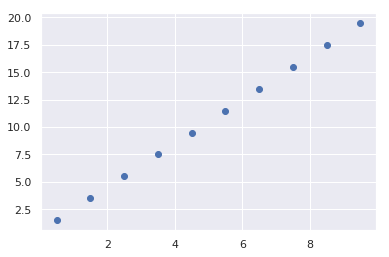

In [ ]:
plt.scatter(df_lin_mean.x, df_lin_mean.y)
plt.show()

In [ ]:
from sklearn import linear_model


class UnivarLinearReg(Operation):
  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Delegate most of the computations to Mean Metrics.
    child = MetricList((Mean(x), Mean(y)))
    self.grp = grp
    # Register grp as the extra_index.
    super(UnivarLinearReg, self).__init__(child, '%s ~ %s' % (y, x), grp)

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    if not split_by:
      yield self.compute_child(df, self.grp), None
    else:
      # grp needs to come after split_by.
      child = self.compute_child(df, split_by + [self.grp])
      keys, indices = list(zip(*child.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield child.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.DataFrame([self.lm.coef_[0], self.lm.intercept_])


lr = UnivarLinearReg('x', 'y', 'grp')
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
class UnivarLinearRegSlow(Metric):
  def __init__(self, x, y, grp):
    self.lm = linear_model.LinearRegression()
    # Doesn't delegate.
    self.x = x
    self.y = y
    self.grp = grp
    super(UnivarLinearRegSlow, self).__init__('%s ~ %s' % (y, x))

  def split_data(self, df, split_by=None):
    """The 1st element in yield will be passed to compute()."""
    idx = split_by + [self.grp] if split_by else self.grp
    mean = df.groupby(idx).mean()
    if not split_by:
      yield mean, None
    else:
      keys, indices = list(zip(*mean.groupby(split_by).groups.items()))
      for i, idx in enumerate(indices):
        yield mean.loc[idx.unique()].droplevel(split_by), keys[i]

  def compute(self, df):
    self.lm.fit(df.iloc[:, [0]], df.iloc[:, 1])
    return pd.Series((self.lm.coef_[0], self.lm.intercept_))


lr_slow = UnivarLinearRegSlow('x', 'y', 'grp')
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

Metric     y ~ x                                      
           Value Jackknife CI-lower Jackknife CI-upper
0       2.000065           1.999928           2.000203
1       0.499577           0.498379           0.500775

In [ ]:
%%timeit
Jackknife('cookie', lr, 0.95).compute_on(df_lin)

1 loops, best of 3: 973 ms per loop


In [ ]:
%%timeit
Jackknife('cookie', lr_slow, 0.95).compute_on(df_lin)

1 loops, best of 3: 1.87 s per loop


## LOWESS

In [ ]:
# Mimics that measurements, y, are taken repeatedly at a fixed grid, x.
np.random.seed(42)
size = 10
x = list(range(5))
df_sin = pd.DataFrame({'x': x * size, 'cookie': np.repeat(range(size), len(x))})
df_sin['y'] = np.sin(df_sin.x) + np.random.normal(scale=0.5, size=len(df_sin.x))
df_sin.head(10)

,x,cookie,y
0,0,0,0.248357
1,1,0,0.772339
2,2,0,1.233142
3,3,0,0.902635
4,4,0,-0.873879
5,0,1,-0.117068
6,1,1,1.631077
7,2,1,1.293015
8,3,1,-0.093617
9,4,1,-0.485522


In [ ]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess


class Lowess(Metric):

  def __init__(self, x, y, name=None, where=None):
    self.x = x
    self.y = y
    name = name or 'LOWESS(%s ~ %s)' % (y, x)
    super(Lowess, self).__init__(name, where=where)

  def compute(self, data):
    lowess_fit = pd.DataFrame(
        lowess(data[self.y], data[self.x]), columns=[self.x, self.y])
    return lowess_fit.drop_duplicates().reset_index(drop=True)

In [ ]:
Lowess('x', 'y') | compute_on(df_sin)

,x,y
0,0.0,0.016953
1,1.0,0.592061
2,2.0,0.575784
3,3.0,-0.109848
4,4.0,-1.096083


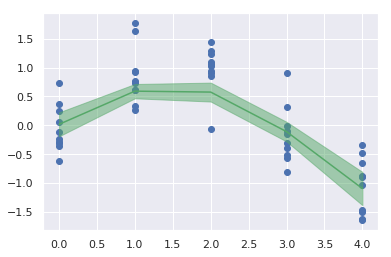

In [ ]:
jk = Lowess('x', 'y') | Jackknife('cookie', confidence=0.9) | compute_on(df_sin)
point_est = jk[('y', 'Value')]
ci_lower = jk[('y', 'Jackknife CI-lower')]
ci_upper = jk[('y', 'Jackknife CI-upper')]

plt.scatter(df_sin.x, df_sin.y)
plt.plot(x, point_est, c='g')
plt.fill_between(
    x, ci_lower,
    ci_upper,
    color='g',
    alpha=0.5)
plt.show()

## Coefficient Shrikage

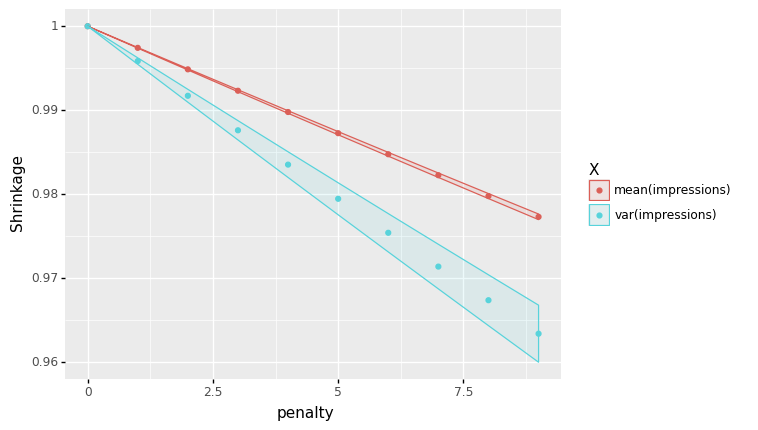

<ggplot: (8791349992637)>

In [ ]:
from plotnine import ggplot, geom_point, geom_ribbon, aes, ylab

y = Mean('clicks')
x = [Mean('impressions'), Variance('impressions')]
grpby = 'platform'
baseline = LinearRegression(y, x, grpby, fit_intercept=False)
shrinkage = [(Ridge(y, x, grpby, a, False) / baseline).rename_columns(
    ('%s::mean(impressions)' % a, '%s::var(impressions)' % a))
             for a in range(10)]
jk = (MetricList(shrinkage)
  | Jackknife('cookie', confidence=0.95)
  | compute_on(df, melted=True)).reset_index()
jk[['penalty', 'X']] = jk.Metric.str.split('::', expand=True)
jk.penalty = jk.penalty.astype(int)

(ggplot(jk, aes('penalty', 'Value', color='X'))
  + ylab('Shrinkage')
  + geom_point()
  + geom_ribbon(
     aes(ymin='Jackknife CI-lower', ymax='Jackknife CI-upper', fill='X'),
     alpha=0.1))